#### 加更多层总是能改进精度吗？
- 嵌套之前的网络，至少不会变差

#### 残差块
- 串联一个层改变类，我们希望能扩大函数类
- 残差块加入到快速通道（后边）来得到
- f(x) = x + g(x)
- 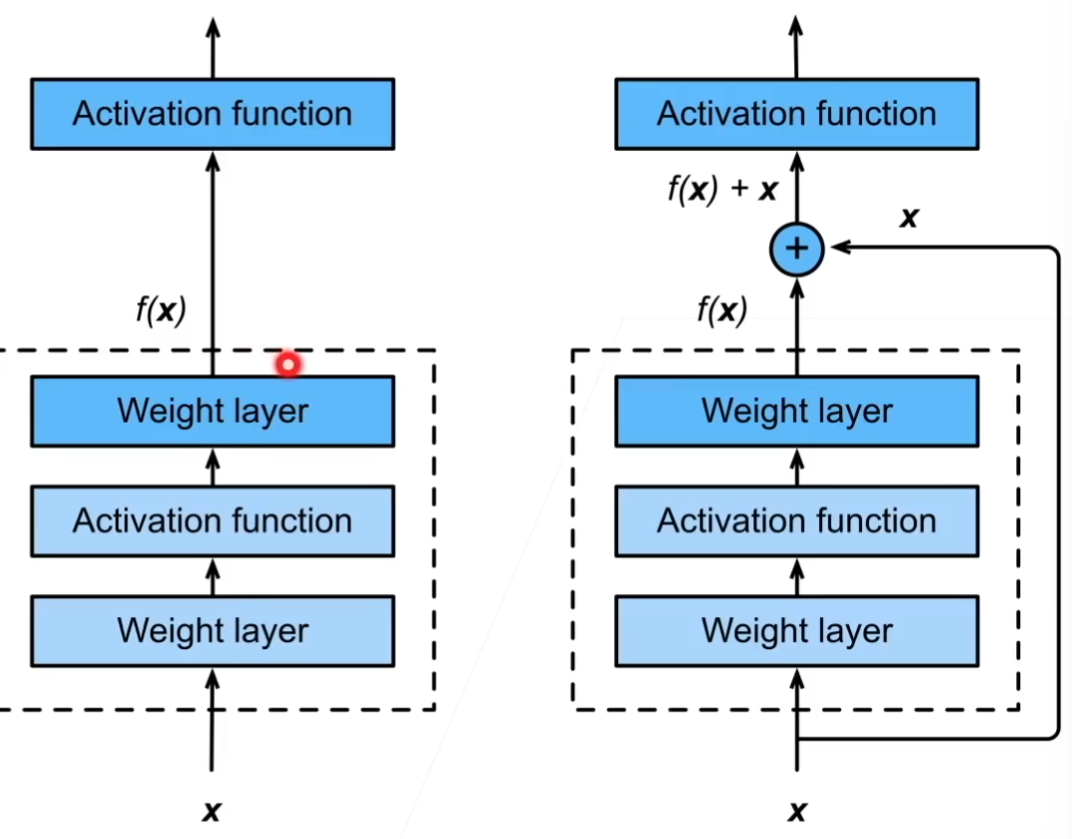

#### ResNet块细节
- 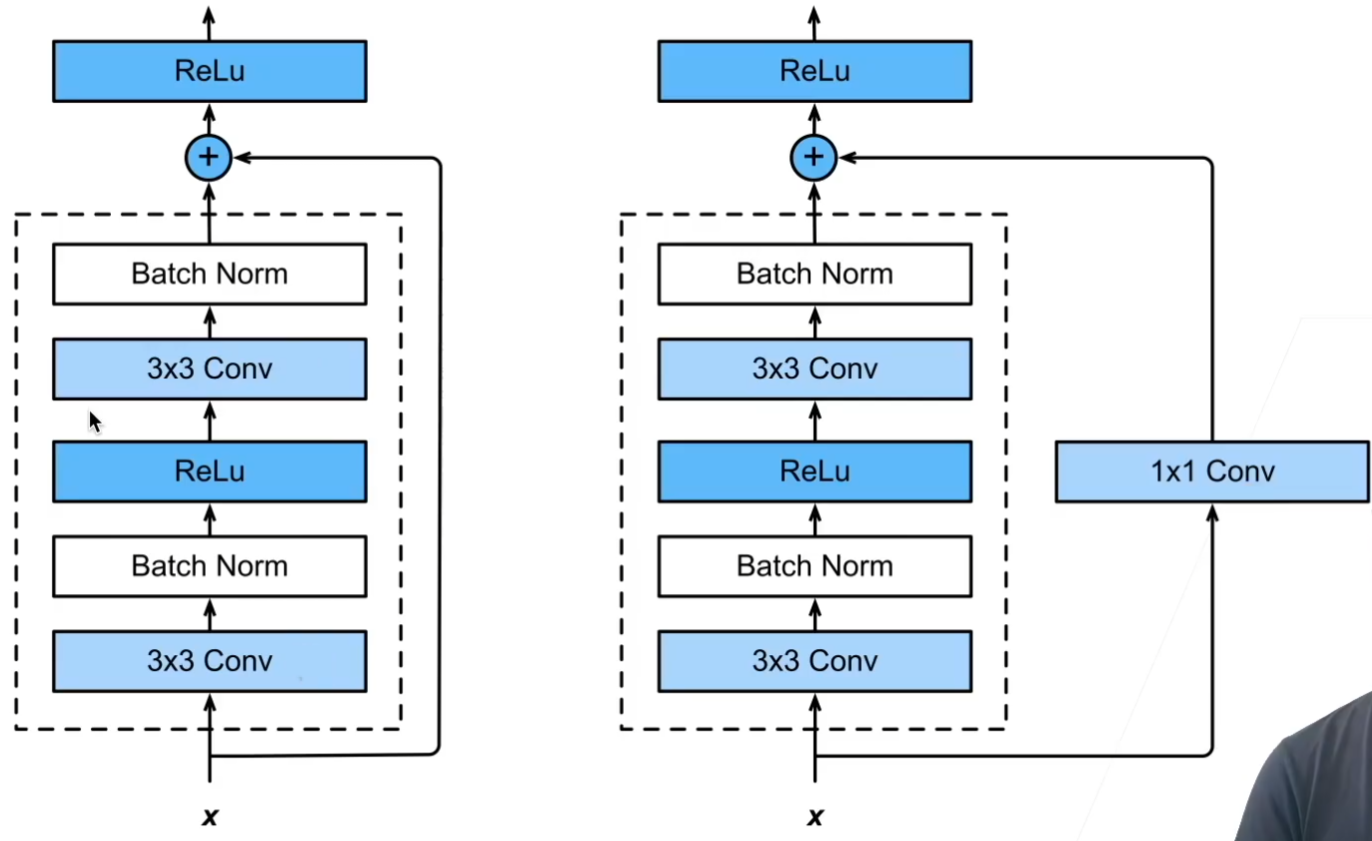

#### 不同的残差块
- 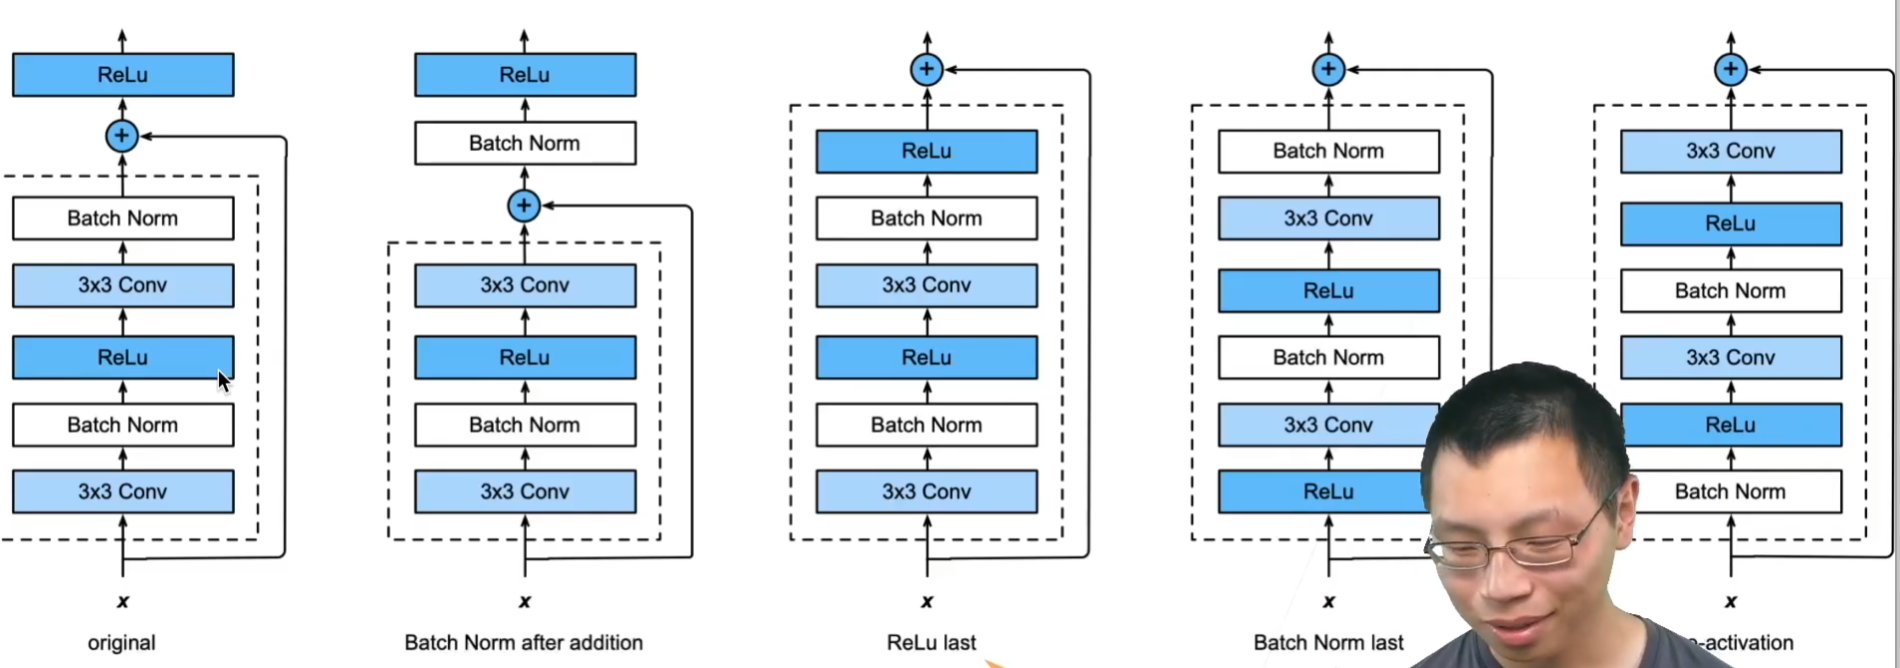

#### ResNet块
- 高宽接班ResNet块（步幅为2）
- 后接多个高宽不变的ResNet块
- 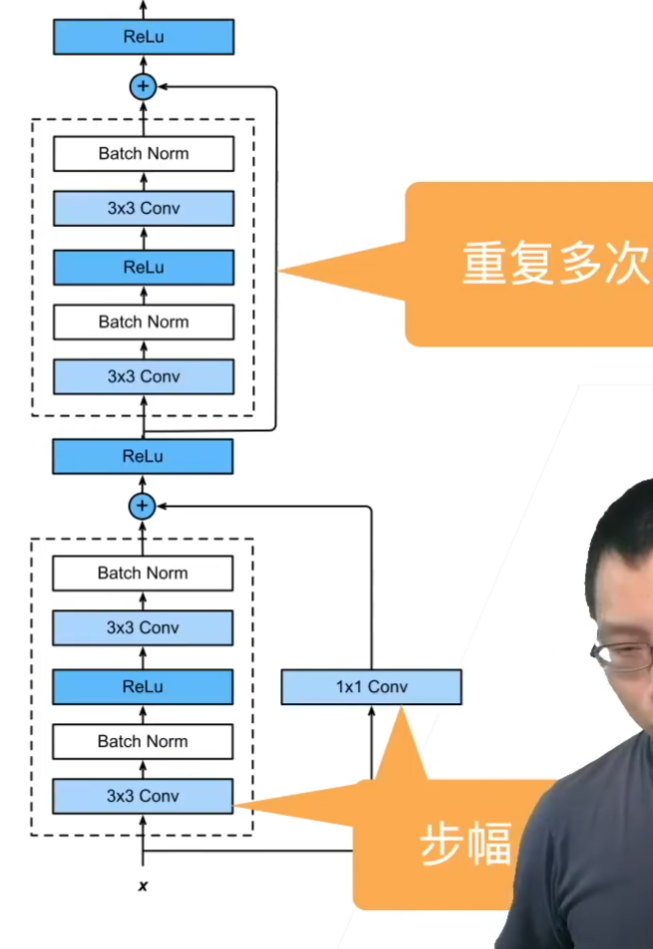

#### ResNet 架构
- 类似VGG和GoogleNet的总体架构
- 但替换成了ResNet块
- 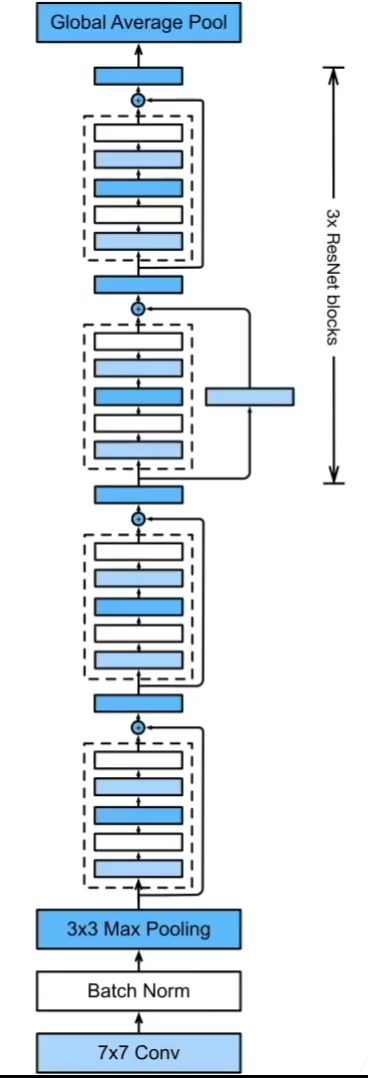
- 一般设计网络都是类似这种，前面7x7卷积然后3x3pooling后面才是自己设计的
- ResNet 152基本用来刷分的，实际用得少，太贵了，大多情况下用的34不行的话最多上个50，实际101和152基本很少用，除非刷榜

### 总结
- 残差块使得很深的网络更易训练
    - 甚至可以训练1k层网络
- 残差网络对随后的深层网络设计产生了深远影响，无论是卷积类网络还是全连接网络

### 代码实现

In [1]:
import torch 
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F

In [20]:
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, 
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2d(
            num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, 
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [21]:
# 输入和输入shape一样
blk = Residual(3, 3)
X = torch.randn(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [22]:
# 增加通道数的同时（一般是加倍），减半输出高宽
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [23]:
## 实现Residual 块
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True,
                               strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [24]:
# 观察一下网络的不同模块输入shape的变化
X = torch.randn(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'out shape：\t', X.shape)

Sequential out shape：	 torch.Size([1, 64, 56, 56])
Sequential out shape：	 torch.Size([1, 64, 56, 56])
Sequential out shape：	 torch.Size([1, 128, 28, 28])
Sequential out shape：	 torch.Size([1, 256, 14, 14])
Sequential out shape：	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d out shape：	 torch.Size([1, 512, 1, 1])
Flatten out shape：	 torch.Size([1, 512])
Linear out shape：	 torch.Size([1, 10])


loss 0.023, train acc 0.995, test acc 0.908
312.0 examples/sec on cuda


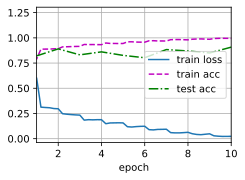

In [25]:
# 训练模型
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device='cuda')

# QA

#### 为什么Lenet batsize大于1000收敛会有问题呢？是nan嘛？
- 不是收敛有问题，而且收敛慢，核心思想在于：当batch_size=1000时，其中不部分图片很相似，多样性相对降低，重复图片重复计算影响收敛精度

#### f(x) = x + g(x)这样就能保证至少不会变坏嘛？万一gx变坏了呢？
- 一般整体不会变坏，主要是如果效果不好的话梯度反传到不了前面基本被忽略

#### cos学习率会比step 固定学习率好嘛？
- 是的，一般效果挺好的，主要是简单

#### 残差网络中的残差体现在哪里？
- 可以理解为先训练小网络，然后在此基础上算差值得出更好的网络，如resnet152可以理解为先在底层学习出了resnet18然后再慢慢学习出大的网络

#### *res中的*是啥意思？
- 是python语法中的展开的意思，如list展开 

#### 训练aac是不是一般都稍高于测试aac？当前有100%识别率吗？
- 不一定哦，比如训练时做data augment时候，训练集中有大量噪声aac会低，但是测试大概率会高
- 基本上不会有100%，没有意义，人标注会有错误率，如imagenet中可能就有5%错误率

# ResNet为什么效果那么好？
- 避免梯度消失，将乘法变加法
- 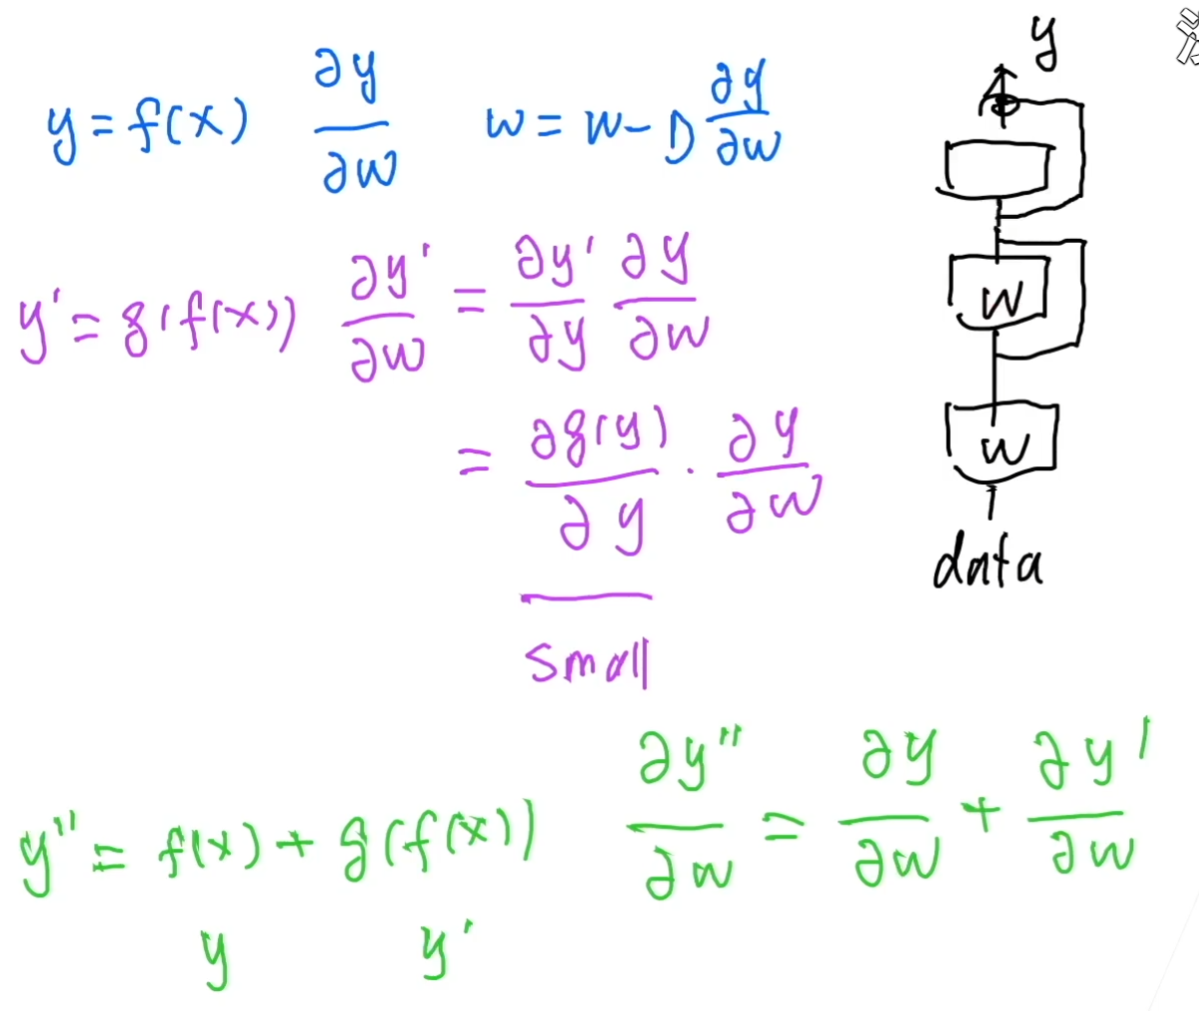
- 出现的核心问题在于底部层的参数拿不到梯度，但是residual设计后，可以直接从最上面一路跳转过来保证底部层w也能拿到较大的梯度来更新参数，而不至于消失

## QA
#### 学习率是不是可以输出的小一点，靠近输入的大一点，会不会缓解梯度消失的问题？
- 可以的，但是问题在于如何调这个大小，不好社，多大多小。
- 如果添加参数又会增加复杂度，还是resnet结构上简单好用
- 而且调参还是考虑稳定性，如果超过float32位会出问题，fp16时更明显